## ROC(Receiver Operating Characteristic) 곡선 그리기

ROC 그래프는 분류기의 임계값을 바꾸어 가며 계산된 FPR과 TPR 점수를 기반으로 분류 모델을 선택한다.</br>
ROC 곡선 아래의 면적(ROC AUC)으로 분류 모델의 성능을 판단할 수 있다.</br>
ROC AUC는 불균형한 데이터셋에서 분류기의 성능에 대해서 더 많은 통찰을 얻을 수 있다.</br>
ROC AUC와 정확도는 대부분 서로 비례한다.</br>

유방암 데이터셋에서 두 개의 특성만 가지고 종양의 악성 여부를 예측하는 모델의 ROC 그래프를 그리면 다음과 같다.

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv(   # 위스콘신 유방암 데이터셋 로딩
    'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', 
    header=None
)

x = df.loc[:, 2:].values    # 30개의 특성을 x에 할당
y = df.loc[:, 1].values     # 클래스 레이블을 y에 할당
y = LabelEncoder().fit_transform(y) # 클래스 레이블을 정수로 변환(악성: 1, 양성: 0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify=y, random_state=1)

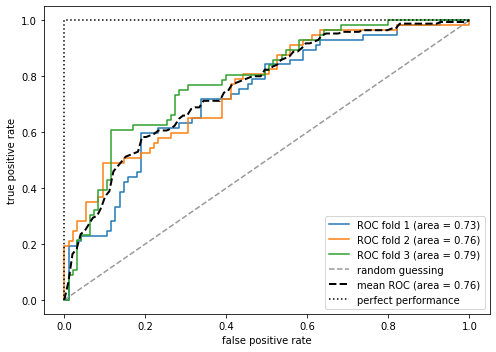

In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(    # 로지스틱회귀 모델 생성
    StandardScaler(),       # 표준화를 사용한 특성 스케일 조정
    PCA(n_components=2),    # PCA를 사용해서 2차원 부분공간으로 데이터 압축
    LogisticRegression(solver='liblinear', penalty='l2', random_state=1, C=100.0)
)

# 두개의 특성만 추출
x_train2 = x_train[:, [4, 14]]

# 계층적 k-겹 교차 검증으로 3개의 폴드로 분리한다.
cv = list(StratifiedKFold(n_splits=3).split(x_train, y_train))
fig = plt.figure(figsize=(7, 5))    # 전체 그래프 화면의 크기 설정

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)   # linspace 함수는 0부터 1사이에 100의 값을 가진 배열로 만들어준다.
all_tpr = []

for i, (train, test) in enumerate(cv):
    # 해당 폴드에 대한 훈련 및 예측을 수행한다.
    probas = pipe_lr.fit(x_train2[train], y_train[train]).predict_proba(x_train2[test])
    # LogisticRegression 모델의 ROC 값을 계산한다.
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    # interp 함수를 사용해서 세 개의 폴드에 대한 ROC 곡선을 보간하여 평균을 구한다.
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    # auc 함수를 사용해서 곡선 아래 면적을 계산한다.
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

평균 ROC AUC(0.76)은 완벽한 경우(1.0)과 랜덤 추측(0.5) 사이에 있다.